## 🔮 Bayes Classifier

We have implemented the Bayes classifier in the previous lab under the normal distribution assumption of $P(X|C)$ and with as well other assumptions to result in LDA and Gaussian Naive Bayes (GNB) and their general form, QDA.

Despite the fact that, thanks to the central limit theorem, many real-life variables do follow the normal distribution which makes QDA one of the most optimal machine learning algorithms you can get your hands on in such cases, many other variables will not follow the normal distribution. For instance, many variables may be categorical (discrete) in the first place or may just follow another distribution (e.g., exponential, lognormal, uniform, etc.) and sometimes we don't even know the mathematical form of the distirbution! 

In summary, we have three cases for what $P(x|C)$ may follow:

- Normal Distribution

- Some other distribution $P(x)$ with known mathematical form and algorithm to estimate its parameters

- An arbitrary distribution $P(x)$ with an unkown mathematical form or parameter estimation method 

The third case is the most general and can be approached with density estimation. Meanwhile, the second and first cases can be more accurate than estimating the density from scratch but require more information.

So far, our Bayes classifier only supports the first case and we want to extend it to support the other two:


#### ✦ Generalize Bayes Classifier to Arbitrary Forms of the Distribution
Our first goal in this lab will be to extend the Bayes Classifier implementation to handle other distributions other than the normal distribution. 

- The user should have the ability to pass their distribution as a function that takes two parameters, the point `x` to evaluate the probability at and a dictionary `params` containing the hyperparameters to then return the probability of the point.

- The user must as well pass an `estimate_params` methods that given a set of $M$ points each of $N$ dimensions `(x_data)` returns the dictionary of parameters `params`.

- Our implementation should automatically estimate the parameters for each class using the `estimate_params` function during `fit` and the parameters should be made ready when needed in a probability estimation `P`.

Implement this in 
```python
fit_custom_density(self, x_train, y_train)
```
and
```python
    def P(self, x, k)->float:
        match self.mode:
            ...
            case 'Custom':
                # implementation goes here
        return P
```

See the test cases below for more information.

#### ✦ Generalize Bayes Classifier to Arbitrary Distribution of Unknown Form

This will make use of the `KDEstimator` class you implemented earlier. The user should be able to pass their kernel density estimator instance which will be used to estimate the density for each class `P(X|C)`

Implement this in 
```python
def fit_kde(self, x_train, y_train)
```
and
```python
def P(self, x, k)->float:
    match self.mode:
        ...
        case 'KDE':
            # implementation goes here
    return P
```

See the test cases below for more information.

### Test Bench

In [15]:
%load_ext autoreload
%autoreload 2
# No need to restart the notebook upon change thanks to autoreload
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from BayesClassifier import BayesClassifier
from KDEstimator import KDEstimator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Generate Synthetic Data

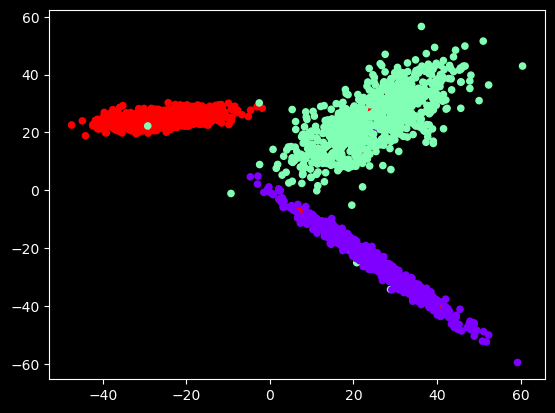

In [16]:
# Generate synthetic data
X, y = make_classification(n_samples=3000, n_features=2, n_classes=3, n_clusters_per_class=1, 
                           random_state=0,  n_informative=2, n_redundant=0, class_sep=2.5, scale=10)
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the data
plt.style.use('dark_background')
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=20, cmap='rainbow')
plt.show()

### 1) Testing KDE

In [17]:
# This is a weak test but the KDE notebook took care of stronger ones
kde = KDEstimator(bump='Gauss', bandwidth='Scott')
kde_clf = BayesClassifier(mode='KDE', kde_config=kde)
kde_clf.fit(x_train, y_train)

# Ensure it's equivalent to using QDA
normal_clf = BayesClassifier(mode='QDA')
normal_clf.fit(x_train, y_train)

# Number of points is large KDE estimate should be just like real assumption (accurate)
np.allclose(kde_clf.predict(x_val), normal_clf.predict(x_val))

True

### 2) Testing Custom Density

In [18]:
from numpy.linalg import det, inv

# Define the density which takes x and the parameters
def N(x, params):
    μ, Σ = params['μ'], params['Σ']
    π, N= np.pi, len(μ)
    P = np.exp(-0.5 * ( (x - μ).T @ inv(Σ) @  (x- μ))) / np.sqrt((2*π)**N * det(Σ))
    return P

# Define a function that estimates the paramers of the density
def estimate_params(x_data):
    μ = np.mean(x_data, axis=0)
    Σ = np.cov(x_data, rowvar=False)
    return {'μ': μ, 'Σ':Σ}

# Consider passing a custom density which is normal distribution in this case
# Normal usecace will certainly be an external distribution but this is just to test
custom_clf = BayesClassifier(mode='Custom', density=N, estimate_params=estimate_params)
custom_clf.fit(x_train, y_train)

# Ensure it's equivalent to using QDA
normal_clf = BayesClassifier(mode='QDA')
normal_clf.fit(x_train, y_train)

# Assert equivalence
np.allclose(custom_clf.predict_proba(x_val), normal_clf.predict_proba(x_val))

True

### 3) Kernel Density & Custom Density Combo Test

Should pass if the two tests above pass. This uses `KDE` as a custom density:

In [19]:
def P(x, params):
    kde = params['kde']
    return kde.transform(x)

# define a function that estimates the paramers of the density
def estimate_params(x_data):
    kde = KDEstimator(bandwidth='Scott', bump='Gauss')
    kde.fit(x_data)
    return {'kde': kde}

custom_clf = BayesClassifier(mode='Custom', density=P, estimate_params=estimate_params)
custom_clf.fit(x_train, y_train)

np.all(kde_clf.predict(x_val) == custom_clf.predict(x_val))

True

#### The following tests are just in case you decide to modify any of the existing Bayes classifier code

### 4) Testing QDA

1.1 Fits without errors

In [20]:
my_classifier = BayesClassifier(mode='QDA')
my_classifier.fit(x_train, y_train)

1.2 Test basic properties of parameters

In [21]:
assert len(my_classifier.means) == len(my_classifier.labels)
assert my_classifier.means[0].shape == (2,)
assert len(my_classifier.covs) == len(my_classifier.labels)
assert my_classifier.covs[0].shape == (2,2)
assert len(my_classifier.priors) == len(my_classifier.labels)
assert my_classifier.priors.sum() == 1

1.3 Test that parameters are set correctly

In [22]:
# compare with scikit parameters
clf = QuadraticDiscriminantAnalysis(store_covariance=True)
clf.fit(x_train, y_train)
assert np.allclose(my_classifier.means, clf.means_)
assert np.allclose(my_classifier.covs, clf.covariance_)
assert np.allclose(my_classifier.priors, clf.priors_)

1.5 Basic test for `predict_proba_x` 

In [23]:
y_pred = my_classifier.predict_proba_x(np.random.rand(2))
assert y_pred.shape == (3,)
assert np.allclose(np.sum(y_pred), 1)

1.6 It follows that `predict_proba` is implemented correctly

In [24]:
assert np.allclose(my_classifier.predict_proba(x_val), clf.predict_proba(x_val))

1.7 Test `predict`

In [25]:
y_pred = my_classifier.predict(x_val)
assert y_pred.shape == y_val.shape
assert np.allclose(y_pred, clf.predict(x_val))

1.8 Test `accuracy`

In [26]:
assert np.allclose(my_classifier.score(x_val, y_val), clf.score(x_val, y_val))

### 5) Testing LDA

In [27]:
my_classifier = BayesClassifier(mode='LDA')
my_classifier.fit(x_train, y_train)

2.1 Test basic properties of parameters

In [28]:
assert len(my_classifier.means) == len(my_classifier.labels)
assert not hasattr(my_classifier, 'covs'), "LDA should not have covs attribute"
assert len(my_classifier.priors) == len(my_classifier.labels)
assert my_classifier.priors.sum() == 1

2.2 Test parameter values

In [29]:
clf = LinearDiscriminantAnalysis(solver='eigen', store_covariance=True)
clf.fit(x_train, y_train)
assert np.allclose(my_classifier.weighted_cov, clf.covariance_)
assert np.allclose(my_classifier.means, clf.means_)
assert np.allclose(my_classifier.priors, clf.priors_)

2.3 Basic test for `predict_proba_x` 

In [30]:
y_pred = my_classifier.predict_proba_x(np.random.rand(2,))
assert y_pred.shape == (3,)
assert np.allclose(np.sum(y_pred), 1)

2.4 End-to-end tests

In [31]:
assert np.allclose(my_classifier.predict_proba(x_val), clf.predict_proba(x_val))

y_pred = my_classifier.predict(x_val)
assert y_pred.shape == y_val.shape
assert np.allclose(y_pred, clf.predict(x_val))

### 6) Testing Gaussian Naive Bayes

In [32]:
my_classifier = BayesClassifier(mode='GNB')
my_classifier.fit(x_train, y_train)

3.1 Test basic properties of parameters

In [33]:
assert len(my_classifier.means) == len(my_classifier.labels)
assert len(my_classifier.covs) == len(my_classifier.labels)
assert len(my_classifier.priors) == len(my_classifier.labels)
assert my_classifier.priors.sum() == 1

3.2 Test parameter values

In [34]:
clf = GaussianNB()
clf.fit(x_train, y_train)
assert np.allclose(my_classifier.priors, clf.class_prior_)
assert np.allclose(my_classifier.means, clf.theta_)
# loop on each row of clf.var_ and ensure the computed variances for a class are the diagonal of corresponding covariance matrix
for i in range(clf.var_.shape[0]): assert np.allclose(my_classifier.covs[i], np.diag(clf.var_[i]))

3.3 End-to-end test

In [35]:
assert np.allclose(my_classifier.predict_proba(x_val), clf.predict_proba(x_val))

y_pred = my_classifier.predict(x_val)
assert y_pred.shape == y_val.shape
assert np.allclose(y_pred, clf.predict(x_val))

<div align="center">
    <img src="https://i.imgur.com/LMiA2O5.gif" width=800/>
</div>